In [69]:
#14	Stock price prediction	Regression with LSTM	Yahoo Finance CSV

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf


In [71]:
data = yf.download("AAPL", start="2010-01-01", end="2025-01-01")
data.columns = [col[0] for col in data.columns]
print(data.head())
data.to_csv("AAPl.csv")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15348\2169949690.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open     Volume
Date                                                         
2010-01-04  6.424604  6.439314  6.375672  6.407193  493729600
2010-01-05  6.435712  6.472036  6.401789  6.442316  601904800
2010-01-06  6.333346  6.461232  6.326741  6.435714  552160000
2010-01-07  6.321636  6.364265  6.275706  6.356760  477131200
2010-01-08  6.363665  6.364266  6.276007  6.313231  447610800


In [72]:
df=pd.read_csv('AAPL.csv')
df
print(df.isnull().sum())
print(df.dtypes)
df['Date']=pd.to_datetime(df['Date'])
print(df['Date'].dtype)
df.drop_duplicates()
from sklearn.preprocessing import MinMaxScaler 

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object
datetime64[ns]


In [73]:
df["Return"]=df["Close"].pct_change()
df["MA10"]=df["Close"].rolling(10).mean()
df["MA50"]=df["Close"].rolling(50).mean()
df["Volatility10"]=df["Return"].rolling(10).std()
df["Lag1"]=df["Close"].shift(1)
df["Lag2"]=df["Close"].shift(2)
df["VolumeChange"]=df["Volume"].pct_change()
df["Target"] =df["Close"].shift(-1)
df=df.dropna()
features=["Close",'Volume','Return',"MA10",'MA50','Volatility10','Lag1',"Lag2",'VolumeChange']
scaler=MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df[features]),columns=features, index=df.index)
y_scaled=scaler.fit_transform(df[["Target"]])
X_scaled["Target"] = y_scaled
print(X_scaled.head())


       Close    Volume    Return      MA10      MA50  Volatility10      Lag1  \
49  0.000263  0.228056  0.528755  0.000000  0.000000      0.131594  0.000190   
50  0.000223  0.230235  0.511870  0.000180  0.000026      0.134299  0.000263   
51  0.000287  0.171645  0.527305  0.000350  0.000053      0.135303  0.000223   
52  0.000000  0.288633  0.474788  0.000391  0.000083      0.069650  0.000287   
53  0.000299  0.233176  0.563063  0.000460  0.000120      0.076316  0.000000   

        Lag2  VolumeChange    Target  
49  0.000519      0.124257  0.000223  
50  0.000190      0.141734  0.000287  
51  0.000263      0.099436  0.000000  
52  0.000223      0.247504  0.000299  
53  0.000287      0.109099  0.000730  


In [74]:
total_len=len(X_scaled)
train_end=int(total_len*0.7)
val_end=int(total_len*0.85)
train=X_scaled.iloc[:train_end]
val=X_scaled.iloc[train_end:val_end]
test=X_scaled.iloc[val_end:]
X_train=train.drop("Target",axis=1)
y_train=train["Target"]
X_val=val.drop("Target",axis=1)
y_val=val["Target"]
X_test = test.drop("Target", axis=1)
y_test = test["Target"]
print(X_train.shape)

(2606, 9)


In [75]:
def create_sequence(X,y,window=60):
    X_seq,y_seq=[],[]
    X_values = X.values  
    y_values = y.values 
    for i in range(len(X_values)-window):
        X_seq.append(X_values[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq),np.array(y_seq)
window=10

X_train_seq,y_train_seq=create_sequence(X_train,y_train,window=10)
X_val_seq,y_val_seq=create_sequence(X_val,y_val,window=10)
X_test_seq,y_test_seq=create_sequence(X_test,y_test,window=10)
print(len(X_test_seq))
print(X_train_seq.shape)
print(y_train_seq.shape)    

549
(2596, 10, 9)
(2596,)


In [76]:
X_train_t=torch.tensor(X_train_seq,dtype=torch.float32)
y_train_t=torch.tensor(y_train_seq,dtype=torch.float32)

X_val_t=torch.tensor(X_val_seq,dtype=torch.float32)
y_val_t=torch.tensor(y_val_seq,dtype=torch.float32)

X_test_t=torch.tensor(X_test_seq,dtype=torch.float32)
y_test_t=torch.tensor(y_test_seq,dtype=torch.float32)

In [77]:
class StockPriceLstm(nn.Module):
    def __init__(self, input_size,hidden_size=64,num_layers=1):
        super().__init__()
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.dropout = nn.Dropout(0.3)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,X):
        out,_=self.lstm(X)
        out = self.dropout(out[:, -1, :])
        out=self.fc(out)
        return out
print(X_train_t.shape)
input_size=X_train_t.shape[2]
model=StockPriceLstm(input_size)

torch.Size([2596, 10, 9])


c:\Users\LENOVO\Documents\pytorch\venvtorch\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [78]:
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.001)
train_dataset=TensorDataset(X_train_t,y_train_t)
val_dataset=TensorDataset(X_val_t,y_val_t)
test_dataset=TensorDataset(X_test_t,y_test_t)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)


In [79]:
patience = 5
best_val_loss = float("inf")
counter = 0

epochs=20
for epoch in range(epochs):
    model.train()
    train_loss=0
    for inputs,targets in train_loader:
        optimizer.zero_grad()
        output=model(inputs)
        loss=criterion(output,targets)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    average_train_loss=train_loss/len(train_loader)

    model.eval()
    val_loss=0
    with torch.no_grad():
        for inputs,targets in val_loader:
            output=model(inputs)
            loss=criterion(output,targets)
            val_loss+=loss.item()
    average_val_loss=val_loss/len(val_loader)

    print(f"epoch {epoch+1},train_loss:{average_train_loss}, val_loss:{average_val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load("best_model.pt"))



c:\Users\LENOVO\Documents\pytorch\venvtorch\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


c:\Users\LENOVO\Documents\pytorch\venvtorch\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LENOVO\Documents\pytorch\venvtorch\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1,train_loss:0.0020007926249513176, val_loss:0.02836188751583298
epoch 2,train_loss:0.0032610789486370332, val_loss:0.011791646325339874
epoch 3,train_loss:0.0011901340809212031, val_loss:0.007510430114861164
epoch 4,train_loss:0.0002748042213014986, val_loss:0.009156285267737176
epoch 5,train_loss:0.00022594055323080705, val_loss:0.007506308094080951
epoch 6,train_loss:0.00023371531296572534, val_loss:0.006490258632564089
epoch 7,train_loss:0.00023144029604204328, val_loss:0.0010913532411602016
epoch 8,train_loss:0.0003164482478917684, val_loss:0.004004601524987568
epoch 9,train_loss:0.00017104532419513662, val_loss:0.0017308882120738013
epoch 10,train_loss:0.00016351125058707377, val_loss:0.001181857951451093
epoch 11,train_loss:0.00014852335898023916, val_loss:0.0021385773401966113
epoch 12,train_loss:0.00015907422815560982, val_loss:0.0018129453561010046
Early stopping triggered!


<All keys matched successfully>

Test MSE Loss: 0.001085199886195672


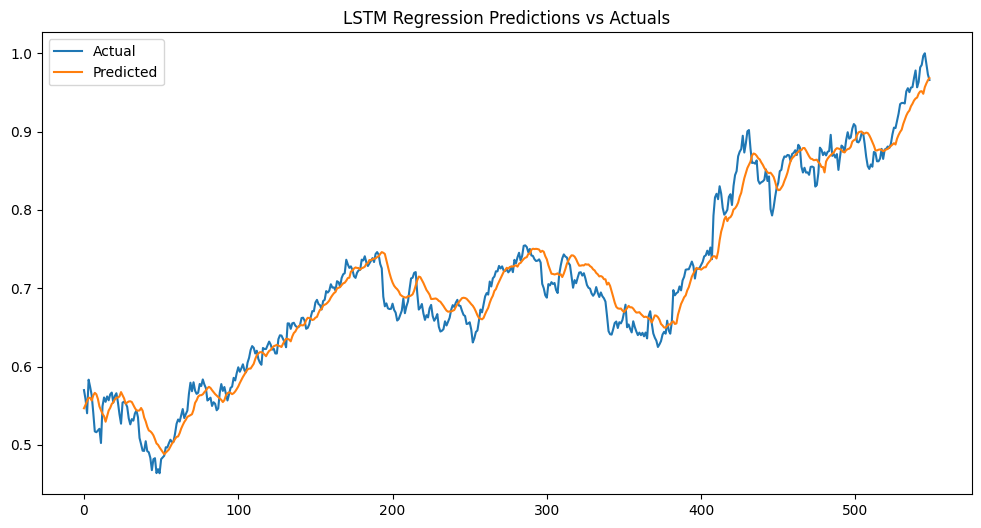

In [80]:
model.eval()
test_losses = []
preds = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)
        test_losses.append(loss.item())
        
        preds.append(outputs.numpy())
        actuals.append(targets.numpy())

# Flatten predictions and actuals
preds = np.concatenate(preds, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Average test loss
avg_test_loss = np.mean(test_losses)
print(f"Test MSE Loss: {avg_test_loss}")

# Optional: plot predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actuals, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title("LSTM Regression Predictions vs Actuals")
plt.show()